# PCA

In [1]:
import numpy as np

file = open("pca_data_online_2.txt","r")

data = []
while True:
    s = file.readline()
    if len(s)==0:
        break
    r = s.split(' ')
    for i in range(len(r)):
        r[i] = float(r[i])
    data.append(r)
data = np.array(data)

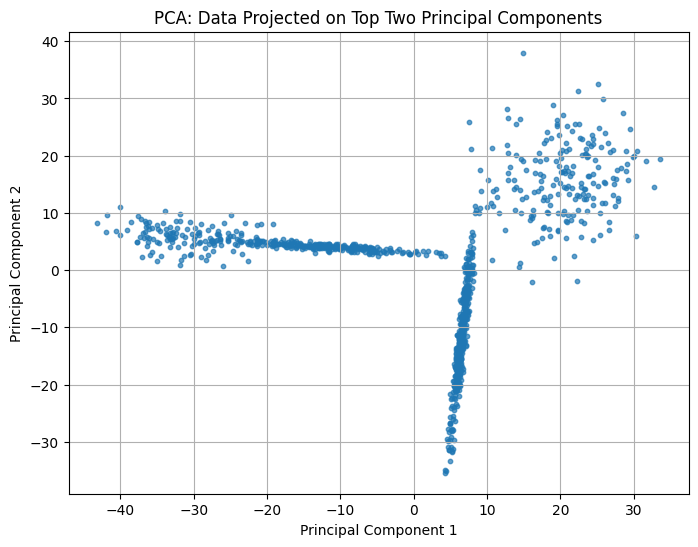

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


data = (data - np.mean(data, axis=0))/np.std(data, axis=0)

n, m = data.shape
covar_matrix = (data.T @ data)/n

eigenvalues, eigenvectors = np.linalg.eig(covar_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

top_two = eigenvectors[:,:2]

conv_data = data @ top_two


plt.figure(figsize=(8, 6))
plt.scatter(conv_data[:, 0], conv_data[:, 1], s=10, alpha=0.7)
plt.title("PCA: Data Projected on Top Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


# UMAP

c:\Users\Naim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


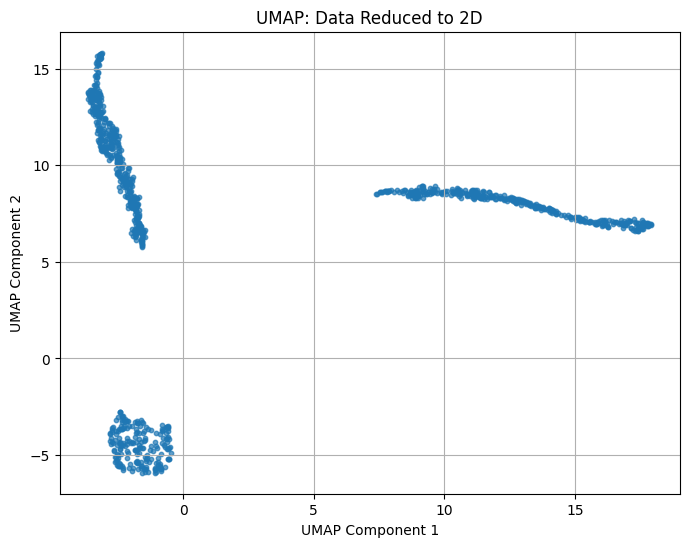

In [3]:
import umap

umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(data)


plt.figure(figsize=(8, 6))
plt.scatter(umap_data[:, 0], umap_data[:, 1], s=10, alpha=0.7)
plt.title("UMAP: Data Reduced to 2D")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

# tSNE

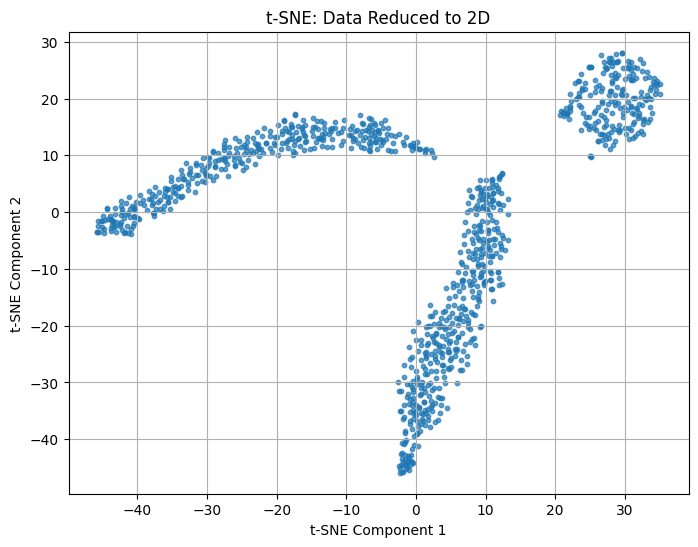

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, alpha=0.7)
plt.title("t-SNE: Data Reduced to 2D")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

# EM Algorithm

In [5]:
import numpy as np

file = open("em_data_online_2.txt","r")

data = []
while True:
    s = file.readline()
    if len(s)==0:
        break
    data.append(float(s))

data = np.array(data).reshape(-1,1)
    

In [6]:
# class GaussianModel:
#     def __init__(self,dim):
#         self.dim = dim
#         self.mean = np.random.rand(self.dim)
#         self.covariance = np.random.rand(self.dim,self.dim)

#     def pmf(self,data):
#         return np.power(2*np.pi,-self.dim/2.0)*np.power(np.linalg.det(self.covariance),-0.5)*np.exp(-0.5*np.sum(((data-self.mean) @ np.linalg.inv(self.covariance))*(data-self.mean),axis=1,keepdims=True))

#     def update(self,res,data):
#         n = np.sum(res,axis=0)
#         self.mean = np.sum(res*data/n,axis=0)
#         self.covariance = (res*(data-self.mean)).T @ (data-self.mean)/n

#     def print_params(self):
#         print(f"Mean: {self.mean}")
#         print(f"Covariance: {self.covariance}")

class PoissonModel:
    def __init__(self,dim=1):
        self.dim = dim
        self.mean = np.random.rand()

    def pmf(self,data):
        log_prob = data * np.log(self.mean) - self.mean - np.vectorize(np.math.lgamma)(data.astype(np.int64) + 1)
        return np.exp(log_prob)
    
    def update(self,res,data):
        n = np.sum(res,axis=0)
        self.mean = np.sum(res*data/n,axis=0)

    def print_params(self):
        print(f"Mean: {self.mean}")

class EM:
    def __init__(self, component, dim, model):
        self.dim = dim
        self.component = component
        self.weights = np.random.rand(self.component)
        self.weights = self.weights/np.sum(self.weights)
        self.models = []
        for i in range(self.component):
            self.models.append(model())
    
    def e_step(self,data):
        res = np.empty((data.shape[0],0))
        for i in self.models:
            res = np.hstack((res,i.pmf(data)))
        
        res = res * self.weights
        res = res / np.sum(res,axis=1,keepdims=True)
        self.res = res


    def m_Step(self,data):
        n = np.sum(self.res,axis=0)
        for i in range(self.component):
            self.models[i].update(self.res[:,i:i+1],data)

        self.weights = n/data.shape[0]

    def log_likelihood(self,data):
        res = np.empty((data.shape[0],0))
        for i in self.models:
            res = np.hstack((res,i.pmf(data)))
        
        res = res * self.weights
        res = np.sum(np.log(np.sum(res,axis=1)))
        return res

    def fit(self,data,max_iteration=1000,threshold=1e-6):
        prev_likelihood = -np.inf
        for i in range(max_iteration):
            self.e_step(data)
            self.m_Step(data)
            curr_likelihood = self.log_likelihood(data)
            print(f"Epoch: {i+1} Likelihood: {curr_likelihood}")

            if np.abs(curr_likelihood-prev_likelihood)<=threshold:
                break

            prev_likelihood = curr_likelihood

        print("Weights: ",self.weights)
        for i in range(self.component):
            print(f"Component {i+1}:")
            self.models[i].print_params()



In [7]:
e = EM(component=2,dim=1,model=lambda: PoissonModel(1))
e.fit(data)

Epoch: 1 Likelihood: -2927.8173523841288
Epoch: 2 Likelihood: -2884.970913362457
Epoch: 3 Likelihood: -2839.2196330936395
Epoch: 4 Likelihood: -2783.819773967316
Epoch: 5 Likelihood: -2718.6769664494195
Epoch: 6 Likelihood: -2645.8270082494964
Epoch: 7 Likelihood: -2567.4076915148976
Epoch: 8 Likelihood: -2487.7723708577882
Epoch: 9 Likelihood: -2416.318082686934
Epoch: 10 Likelihood: -2365.610154873024
Epoch: 11 Likelihood: -2339.338355798438
Epoch: 12 Likelihood: -2329.062633708957
Epoch: 13 Likelihood: -2325.6805615203793
Epoch: 14 Likelihood: -2324.6572092570023
Epoch: 15 Likelihood: -2324.359206893695
Epoch: 16 Likelihood: -2324.273965280152
Epoch: 17 Likelihood: -2324.2497937244243
Epoch: 18 Likelihood: -2324.242969494804
Epoch: 19 Likelihood: -2324.2410471907874
Epoch: 20 Likelihood: -2324.2405063382344
Epoch: 21 Likelihood: -2324.240354260097
Epoch: 22 Likelihood: -2324.240311512376
Epoch: 23 Likelihood: -2324.2402994984823
Epoch: 24 Likelihood: -2324.2402961223825
Epoch: 25 Li

C:\Users\Naim\AppData\Local\Temp\ipykernel_14060\2821276945.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_prob = data * np.log(self.mean) - self.mean - np.vectorize(np.math.lgamma)(data.astype(np.int64) + 1)
